In [1]:
import os
import json
import requests
from bs4 import BeautifulSoup
from typing import List
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai

import gradio as gr

In [2]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

OpenAI API Key exists and begins sk-proj-
Google API Key exists and begins AIzaSyB6


In [3]:
# Connect to OpenAI, Anthropic and Google; comment out the Claude or Google lines if you're not using them

openai = OpenAI()

google.generativeai.configure()

In [16]:
# A generic system message - no more snarky adversarial AIs!

system_message = "You are a helpful assistant"

def message_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
    ]
    completion = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
    )
    print(completion)
    return completion.choices[0].message.content

In [41]:
message_gpt("What is today's date?")

ChatCompletion(id='chatcmpl-AvMtwYQmjB3qmfE1YIsczqAh6sq1G', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Today's date is October 13, 2023.", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1738236092, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_72ed7ab54c', usage=CompletionUsage(completion_tokens=12, prompt_tokens=21, total_tokens=33, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


"Today's date is October 13, 2023."

In [ ]:
# here's a simple function

def shout(text):
    print(f"Shout has been called with input {text}")
    return text.upper()

In [ ]:
shout("hello")

In [ ]:
# The simplicty of gradio. This might appear in "light mode" - I'll show you how to make this in dark mode later.

gr.Interface(fn=shout, inputs="textbox", outputs="textbox").launch()

In [ ]:
# Adding share=True means that it can be accessed publically
# A more permanent hosting is available using a platform called Spaces from HuggingFace, which we will touch on next week
# NOTE: Some Anti-virus software and Corporate Firewalls might not like you using share=True. If you're at work on on a work network, I suggest skip this test.

gr.Interface(fn=shout, inputs="textbox", outputs="textbox", flagging_mode="never").launch(share=True)

In [ ]:
# Adding inbrowser=True opens up a new browser window automatically

gr.Interface(fn=shout, inputs="textbox", outputs="textbox", flagging_mode="never").launch(inbrowser=True)

In [ ]:
# Define this variable and then pass js=force_dark_mode when creating the Interface

force_dark_mode = """
function refresh() {
    const url = new URL(window.location);
    if (url.searchParams.get('__theme') !== 'dark') {
        url.searchParams.set('__theme', 'dark');
        window.location.href = url.href;
    }
}
"""
gr.Interface(fn=shout, inputs="textbox", outputs="textbox", flagging_mode="never", js=force_dark_mode).launch()

In [19]:
# Inputs and Outputs

view = gr.Interface(
    fn=shout,
    inputs=[gr.Textbox(label="Your message:", lines=6)],
    outputs=[gr.Textbox(label="Response:", lines=8)],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


In [20]:
# And now - changing the function from "shout" to "message_gpt"

view = gr.Interface(
    fn=message_gpt,
    inputs=[gr.Textbox(label="Your message:", lines=6)],
    outputs=[gr.Textbox(label="Response:", lines=8)],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [17]:
# Let's create a call that streams back results
# If you'd like a refresher on Generators (the "yield" keyword),
# Please take a look at the Intermediate Python notebook in week1 folder.

def stream_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )
    result = ""
    for chunk in stream:
        result += chunk.choices[0].delta.content or ""
        yield result

In [18]:
view = gr.Interface(
    fn=stream_gpt,
    inputs=[gr.Textbox(label="Your message:")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [21]:
def stream_model(prompt, model):
    if model=="GPT":
        result = stream_gpt(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result

In [22]:
view = gr.Interface(
    fn=stream_model,
    inputs=[gr.Textbox(label="Your message:"), gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [23]:
MODEL = 'gpt-4o-mini'
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    print("History is:")
    print(history)
    print("And messages is:")
    print(messages)
    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [24]:
gr.ChatInterface(fn=chat, type="messages").launch()


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [25]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [26]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [27]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [28]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [29]:
# Getting OpenAI to use the Tool

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    print(response)
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    return response.choices[0].message.content

In [30]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [31]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [32]:
import base64
from io import BytesIO
from PIL import Image

In [33]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

In [ ]:
# let's make a function talker that uses OpenAI's speech model to generate Audio

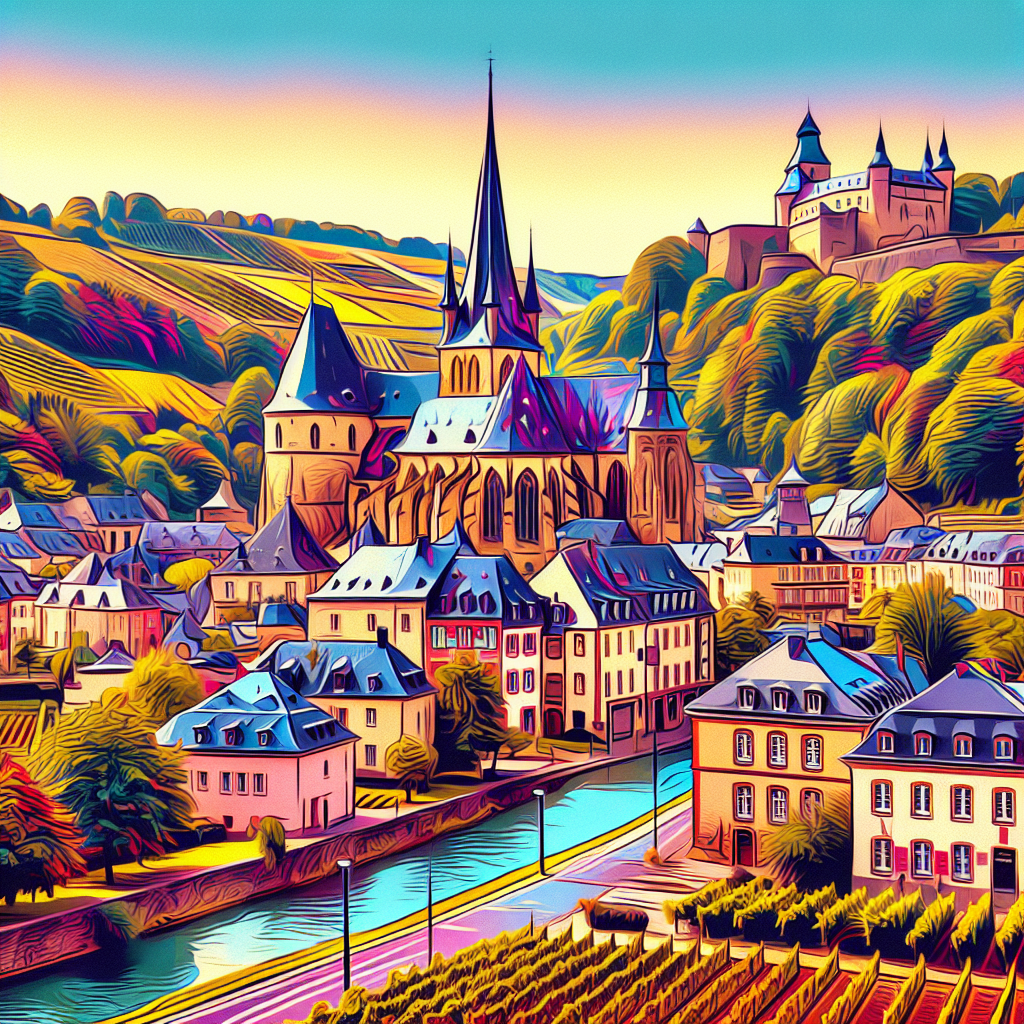

In [51]:
image = artist("Luxembourg")
display(image)

In [5]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [9]:
talker("Well, hi there")

Input #0, wav, from '/var/folders/hb/_y2tps0n0m77ytw9p5xk3kx41dbrb_/T/tmpqpbe1oqj.wav':
  Duration: 00:00:00.77, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.58 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

   0.65 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [10]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

In [11]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # Set a custom directory for temporary files on Windows
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # You can also use 'TMP' if necessary
    
    # Create the folder if it doesn't exist
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

talker("Well hi there")

Input #0, wav, from '/var/folders/hb/_y2tps0n0m77ytw9p5xk3kx41dbrb_/T/tmpxx0dlb90.wav':
  Duration: 00:00:00.82, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.74 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [12]:
!pip install simpleaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... one
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-macosx_11_0_arm64.whl size=2031695 sha256=d468e2f0323721cf97fb6072f3ef4a407952e5bb101bec22f3a5276983d19f23
  Stored in directory: /Users/yu.pei/Library/Caches/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio


In [34]:
MODEL = "gpt-4o-mini"

def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [35]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/hb/_y2tps0n0m77ytw9p5xk3kx41dbrb_/T/tmp70gb42ny.wav':
  Duration: 00:00:17.95, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
  17.88 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 